# 1. Install Dependencies and Setup

In [14]:
!pip install tensorflow
!pip install tensorflow-gpu
!pip install opencv-python
!pip install matplotlib

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Num GPUs Available:  0


In [2]:
!pip install tensorflow-gpu
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Num GPUs Available:  1


In [3]:
import tensorflow as tf
import os

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Remove dodgy images

In [6]:
import cv2
import imghdr

In [9]:
data_dir = 'data'

In [8]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [11]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [12]:
import numpy as np
from matplotlib import pyplot as plt

In [13]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 388 files belonging to 2 classes.


In [14]:
data_iterator = data.as_numpy_iterator()

In [15]:
batch = data_iterator.next()

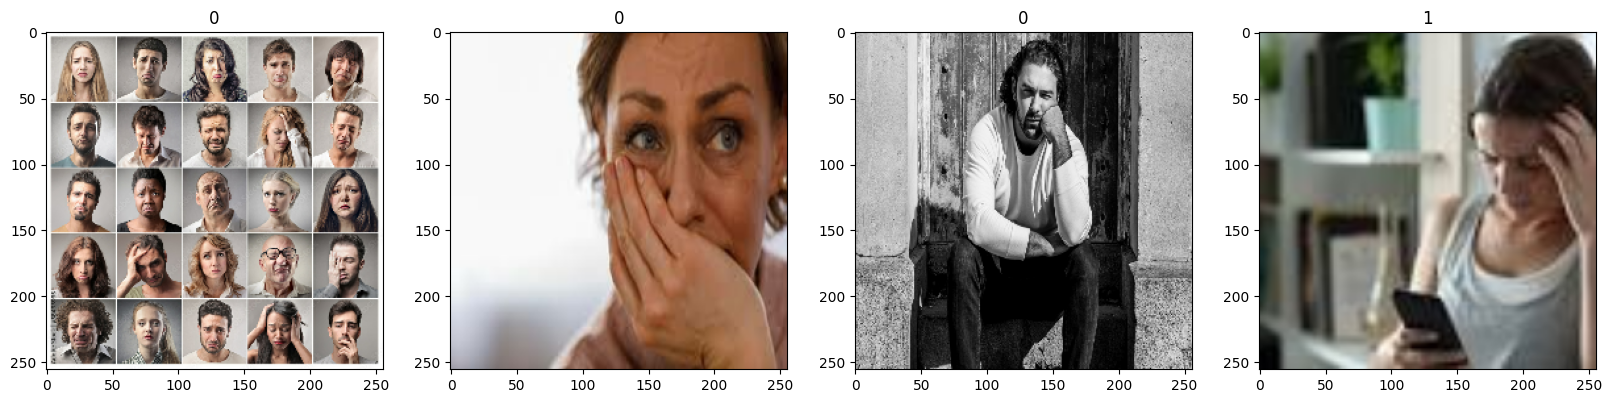

In [16]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [17]:
data = data.map(lambda x,y: (x/255, y))

In [18]:
data.as_numpy_iterator().next()

(array([[[[5.88235296e-02, 7.05882385e-02, 9.01960805e-02],
          [5.88235296e-02, 7.05882385e-02, 9.01960805e-02],
          [5.88235296e-02, 7.05882385e-02, 9.01960805e-02],
          ...,
          [5.88235296e-02, 7.05882385e-02, 9.01960805e-02],
          [5.88235296e-02, 7.05882385e-02, 9.01960805e-02],
          [5.88235296e-02, 7.05882385e-02, 9.01960805e-02]],
 
         [[5.88235296e-02, 7.05882385e-02, 9.01960805e-02],
          [5.88235296e-02, 7.05882385e-02, 9.01960805e-02],
          [5.88235296e-02, 7.05882385e-02, 9.01960805e-02],
          ...,
          [5.88235296e-02, 7.05882385e-02, 9.01960805e-02],
          [5.88235296e-02, 7.05882385e-02, 9.01960805e-02],
          [5.88235296e-02, 7.05882385e-02, 9.01960805e-02]],
 
         [[5.88235296e-02, 7.05882385e-02, 9.01960805e-02],
          [5.88235296e-02, 7.05882385e-02, 9.01960805e-02],
          [5.88235296e-02, 7.05882385e-02, 9.01960805e-02],
          ...,
          [5.88235296e-02, 7.05882385e-02, 9.0196

# 5. Split Data

In [19]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [20]:
train_size

9

In [21]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [22]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [24]:
model = Sequential()

In [25]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# 7. Train

In [28]:
logdir='logs'

In [29]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [30]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 588ms/step - accuracy: 0.5231 - loss: 0.9496 - val_accuracy: 0.5469 - val_loss: 0.6904
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 976ms/step - accuracy: 0.6756 - loss: 0.6675 - val_accuracy: 0.5781 - val_loss: 0.6724
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 891ms/step - accuracy: 0.6066 - loss: 0.6807 - val_accuracy: 0.5625 - val_loss: 0.6762
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 669ms/step - accuracy: 0.6007 - loss: 0.6775 - val_accuracy: 0.6406 - val_loss: 0.6521
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 894ms/step - accuracy: 0.5692 - loss: 0.6674 - val_accuracy: 0.6719 - val_loss: 0.6065
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 919ms/step - accuracy: 0.6059 - loss: 0.6567 - val_accuracy: 0.6250 - val_loss: 0.6359
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 984ms/step - accuracy: 0.5999 - loss: 0.6528 - val_accuracy: 0.6094 - val_loss: 0.6478
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 604ms/step - accuracy: 0.6688 - loss: 0.5984 - val_accuracy: 0.6562 - val_loss

# 8. Plot Performance

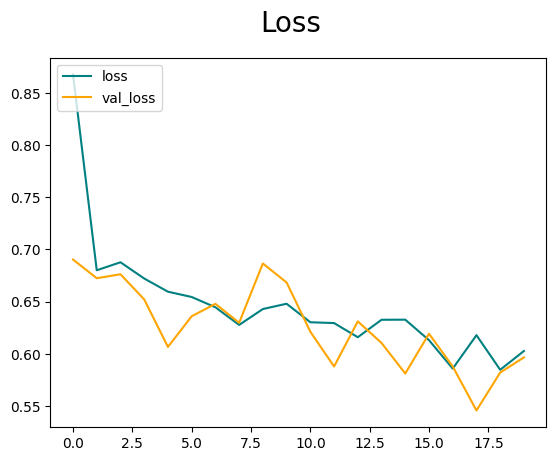

In [31]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

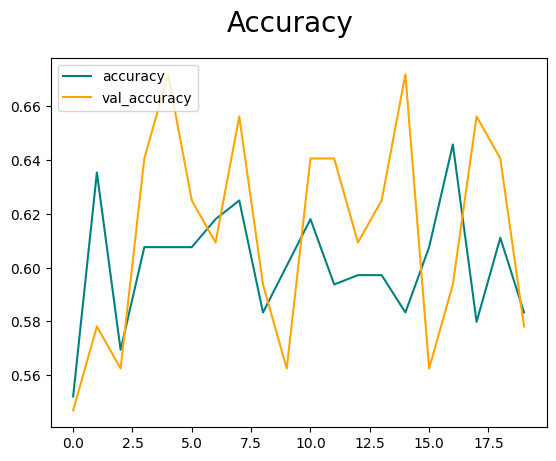

In [32]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [47]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [34]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [46]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [36]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.85714287, shape=(), dtype=float32) tf.Tensor(0.3529412, shape=(), dtype=float32) tf.Tensor(0.625, shape=(), dtype=float32)


# 10. Test

In [37]:
import cv2

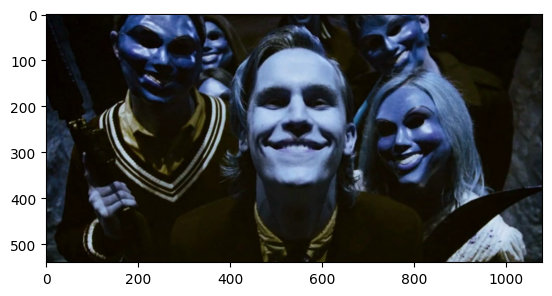

In [69]:
img = cv2.imread('/content/data/happy/07-120104-happy_people_are_not_nice_people.jpg')
plt.imshow(img)
plt.show()

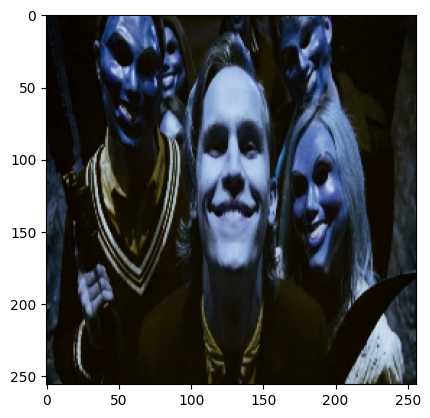

In [70]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [71]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [72]:
yhat

array([[0.14728208]], dtype=float32)

In [73]:
if yhat > 0.3:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


# 11. Save the Model

In [43]:
from tensorflow.keras.models import load_model

In [50]:
model.save(os.path.join('models','imageclassifier.h5'))

NameError: name 'new_model' is not defined